In [1]:
import pandas as pd
import os
import numpy as np
import requests
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import datetime
import time
import json
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import openmeteo_requests
import requests_cache
from retry_requests import retry
import hsfs
from pathlib import Path
from dotenv import load_dotenv
import hopsworks
import sys

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

from format_data import format_weather_data, format_price_data, merge_data
from get_electricity_prices import get_data
from get_weather_data import get_historical_weather, get_weather_forecast

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
if not os.getenv("CI"):  # CI is a common variable set in GitHub Actions
    load_dotenv()
    
hopsworks_api = os.getenv("HOPSWORKS_API_KEY")
entose_api = os.getenv("ENTSOE_API")

if not hopsworks_api:
    raise ValueError("HOPSWORKS_API_KEY is not set.")
if not entose_api:
    raise ValueError("ENTSOE_API is not set.")

os.environ["ENTSOE_API"] = entose_api
os.environ["HOPSWORKS_API_KEY"] = hopsworks_api

project = hopsworks.login()
fs = project.get_feature_store() 
print(f"Connected to project: {project.name}")

2025-01-07 12:46:02,153 INFO: Initializing external client
2025-01-07 12:46:02,154 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-07 12:46:04,042 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1164446
Connected to project: oskaralf


In [3]:
feature_view = fs.get_feature_view(
    name='electricity_price_fv_3',
    version=1,
)

In [4]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="electricity_xgboost_model_se3",
    version=1,
)
saved_model_dir = retrieved_model.download()

In [5]:
saved_model_dir
retrieved_xgboost_model = xgb.XGBRegressor()
retrieved_xgboost_model.load_model(saved_model_dir + "/model_se3.json")
retrieved_xgboost_model

XGBRegressor(base_score='8.778864E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [6]:
weather_fg = fs.get_feature_group(
    name='weather_data_3',
    version=1,
)
entsoe_fg = fs.get_feature_group(
    name='entsoe_data_3',
    version=1,
)
entsoe_fg = fs.get_feature_group(name='entsoe_data_3', version=1)
weather_fg = fs.get_feature_group(name='weather_data_3', version=1)

# Read the data from the feature groups into pandas DataFrames
entsoe_df = entsoe_fg.read()
weather_df = weather_fg.read()

# Ensure 'date' columns are of the same datetime64[ns] type and timezone
entsoe_df['date'] = pd.to_datetime(entsoe_df['date']).dt.tz_convert('UTC')
weather_df['date'] = pd.to_datetime(weather_df['date']).dt.tz_convert('UTC')

last_date = entsoe_df['date'].max()
print("Last date in the entsoe data:", last_date)
#batch_data = pd.merge(weather_data, entsoe_data, on='date', how='inner')
#print(weather_df[(weather_df['date'] >= last_date - pd.Timedelta(hours=1)) & 
                 #(weather_df['date'] <= last_date + pd.Timedelta(hours=1))]['date'])

weather_data = weather_fg.filter((weather_fg['date'] >= last_date - pd.Timedelta(hours=1)) & 
                                 (weather_fg['date'] <= last_date + pd.Timedelta(hours=1))).read()
#batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.82s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 
Last date in the entsoe data: 2025-01-07 10:00:00+00:00
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 


In [7]:
print(weather_data)

                       date  temperature_2m  precipitation  wind_speed_100m  \
0 2025-01-07 11:00:00+00:00          4.0175            0.0        45.572357   
1 2025-01-07 10:00:00+00:00          3.4675            0.0        42.316463   
2 2025-01-07 12:00:00+00:00          4.1175            0.0        48.824814   

   temperature_2m_lag  precipitation_lag  wind_speed_100m_lag  
0              3.4675                0.0            42.316463  
1              3.0175                0.0            41.312252  
2              4.0175                0.0            45.572357  


In [8]:
batch_data = pd.merge(weather_data, entsoe_df, on='date', how='inner')

In [9]:
batch_data

,date,temperature_2m,precipitation,wind_speed_100m,temperature_2m_lag,precipitation_lag,wind_speed_100m_lag,prices,imported_energy,total_load,total_generation_se,prices_lag,imported_energy_lag,total_load_lag,total_generation_se_lag,future_price
0,2025-01-07 10:00:00+00:00,3.4675,0.0,42.316463,3.0175,0.0,41.312252,34.27,-1159.0,36067.5,4668.0,35.01,-1274.0,35931.0,4304.0,NaN


In [10]:
batch_data = batch_data.drop(columns = ['precipitation', 'precipitation_lag', 'future_price'])

In [11]:
print(batch_data.columns)

Index(['date', 'temperature_2m', 'wind_speed_100m', 'temperature_2m_lag',
       'wind_speed_100m_lag', 'prices', 'imported_energy', 'total_load',
       'total_generation_se', 'prices_lag', 'imported_energy_lag',
       'total_load_lag', 'total_generation_se_lag'],
      dtype='object')


In [12]:
column_order = ['date', 'prices', 'imported_energy', 'total_load', 'total_generation_se',
       'prices_lag', 'imported_energy_lag', 'total_load_lag',
       'total_generation_se_lag', 'temperature_2m', 'wind_speed_100m',
       'temperature_2m_lag', 'wind_speed_100m_lag']

batch_data = batch_data[column_order]

In [13]:
print(batch_data)

                       date  prices  imported_energy  total_load  \
0 2025-01-07 10:00:00+00:00   34.27          -1159.0     36067.5   

   total_generation_se  prices_lag  imported_energy_lag  total_load_lag  \
0               4668.0       35.01              -1274.0         35931.0   

   total_generation_se_lag  temperature_2m  wind_speed_100m  \
0                   4304.0          3.4675        42.316463   

   temperature_2m_lag  wind_speed_100m_lag  
0              3.0175            41.312252  


In [14]:
batch_data['predicted_electricity_price'] = retrieved_xgboost_model.predict(
    batch_data[['prices', 'imported_energy', 'total_load', 'total_generation_se',
       'prices_lag', 'imported_energy_lag', 'total_load_lag',
       'total_generation_se_lag', 'temperature_2m', 'wind_speed_100m',
       'temperature_2m_lag', 'wind_speed_100m_lag']])
batch_data

,date,prices,imported_energy,total_load,total_generation_se,prices_lag,imported_energy_lag,total_load_lag,total_generation_se_lag,temperature_2m,wind_speed_100m,temperature_2m_lag,wind_speed_100m_lag,predicted_electricity_price
0,2025-01-07 10:00:00+00:00,34.27,-1159.0,36067.5,4668.0,35.01,-1274.0,35931.0,4304.0,3.4675,42.316463,3.0175,41.312252,35.446297


In [15]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         1 non-null      datetime64[us, Etc/UTC]
 1   prices                       1 non-null      float64                
 2   imported_energy              1 non-null      float64                
 3   total_load                   1 non-null      float64                
 4   total_generation_se          1 non-null      float64                
 5   prices_lag                   1 non-null      float64                
 6   imported_energy_lag          1 non-null      float64                
 7   total_load_lag               1 non-null      float64                
 8   total_generation_se_lag      1 non-null      float64                
 9   temperature_2m               1 non-null      float32                
 10  wind_s

In [16]:
monitor_fg = fs.get_or_create_feature_group(
    name='electricity_prediction_fg',
    version=1,
    primary_key=['date'],
    description='Predicted electricity prices for SE3',
    event_time='date',
)

In [17]:
print(batch_data)

                       date  prices  imported_energy  total_load  \
0 2025-01-07 10:00:00+00:00   34.27          -1159.0     36067.5   

   total_generation_se  prices_lag  imported_energy_lag  total_load_lag  \
0               4668.0       35.01              -1274.0         35931.0   

   total_generation_se_lag  temperature_2m  wind_speed_100m  \
0                   4304.0          3.4675        42.316463   

   temperature_2m_lag  wind_speed_100m_lag  predicted_electricity_price  
0              3.0175            41.312252                    35.446297  


In [18]:
monitor_fg.insert(batch_data)

Uploading Dataframe: 100.00% |██████████| Rows 1/1 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: electricity_prediction_fg_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1164446/jobs/named/electricity_prediction_fg_1_offline_fg_materialization/executions


(Job('electricity_prediction_fg_1_offline_fg_materialization', 'SPARK'), None)

In [19]:
plot_data = monitor_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.58s) 


In [20]:
plot_data

,date,prices,imported_energy,total_load,total_generation_se,prices_lag,imported_energy_lag,total_load_lag,total_generation_se_lag,temperature_2m,wind_speed_100m,temperature_2m_lag,wind_speed_100m_lag,predicted_electricity_price
0,2025-01-06 20:00:00+00:00,24.86,-1658.0,34000.00,5033.0,28.01,-1285.0,34604.00,4911.0,0.8175,50.117638,0.8675,51.348923,22.932186
1,2025-01-06 19:00:00+00:00,28.01,-1285.0,34604.00,4911.0,31.58,-1516.0,35305.00,4833.0,0.8675,50.137028,0.7675,47.328705,22.882574
2,2025-01-06 21:00:00+00:00,13.82,-2363.0,33323.25,5055.0,24.86,-1658.0,34000.00,5033.0,0.7175,44.074646,0.8175,50.117638,13.323219
3,2025-01-07 01:00:00+00:00,8.71,-3128.0,30694.75,4345.0,13.60,-2941.0,30968.00,4463.0,0.7675,45.195412,0.8175,45.337139,9.694694
4,2025-01-07 02:00:00+00:00,8.90,-2932.0,30432.75,4133.0,8.71,-3128.0,30694.75,4345.0,0.8675,43.274933,0.7675,46.790306,9.856896
5,2025-01-07 03:00:00+00:00,5.01,-2810.0,30324.25,3987.0,8.90,-2932.0,30432.75,4133.0,0.8675,35.066292,0.8675,43.274933,8.671361
6,2025-01-07 04:00:00+00:00,5.13,-3010.0,30487.50,3871.0,5.01,-2810.0,30324.25,3987.0,1.1675,20.150354,0.8675,35.309372,21.142136
7,2025-01-07 05:00:00+00:00,5.80,-3050.0,31552.00,3857.0,5.13,-3010.0,30487.50,3871.0,1.9675,39.792622,1.1675,20.150354,12.217891
8,2025-01-07 06:00:00+00:00,44.81,-2570.0,33093.50,3896.0,5.80,-3050.0,31552.00,3857.0,2.3175,40.872288,1.9675,39.792622,75.319519
9,2025-01-07 07:00:00+00:00,38.03,-1885.0,34993.50,4191.0,44.81,-2570.0,33093.50,3896.0,2.5175,40.425930,2.3175,40.838982,40.018734


In [22]:
first = plot_data['predicted_electricity_price'].iloc[-1]
second = plot_data['predicted_electricity_price'].iloc[-2]
change = round((first - second) / second,4)

In [24]:

d = plot_data['date'].iloc[-1] + pd.Timedelta(hours=2)
hour = d.strftime('%H:%M')
plus_1 = d + pd.Timedelta(hours=1)
interval = plus_1.strftime('%H:%M')
if change < 0:
    text = f'Price is likely to decrease by {round(abs(change)*100, 2)}% from {hour} to {interval}'
else:
    text = f'Price is likely to increase by {round(change*100, 2)}% from {hour} to {interval}'
print(text)

Price is likely to decrease by 4.98% from 12:00 to 13:00


2025-01-07 12:47:32,020 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



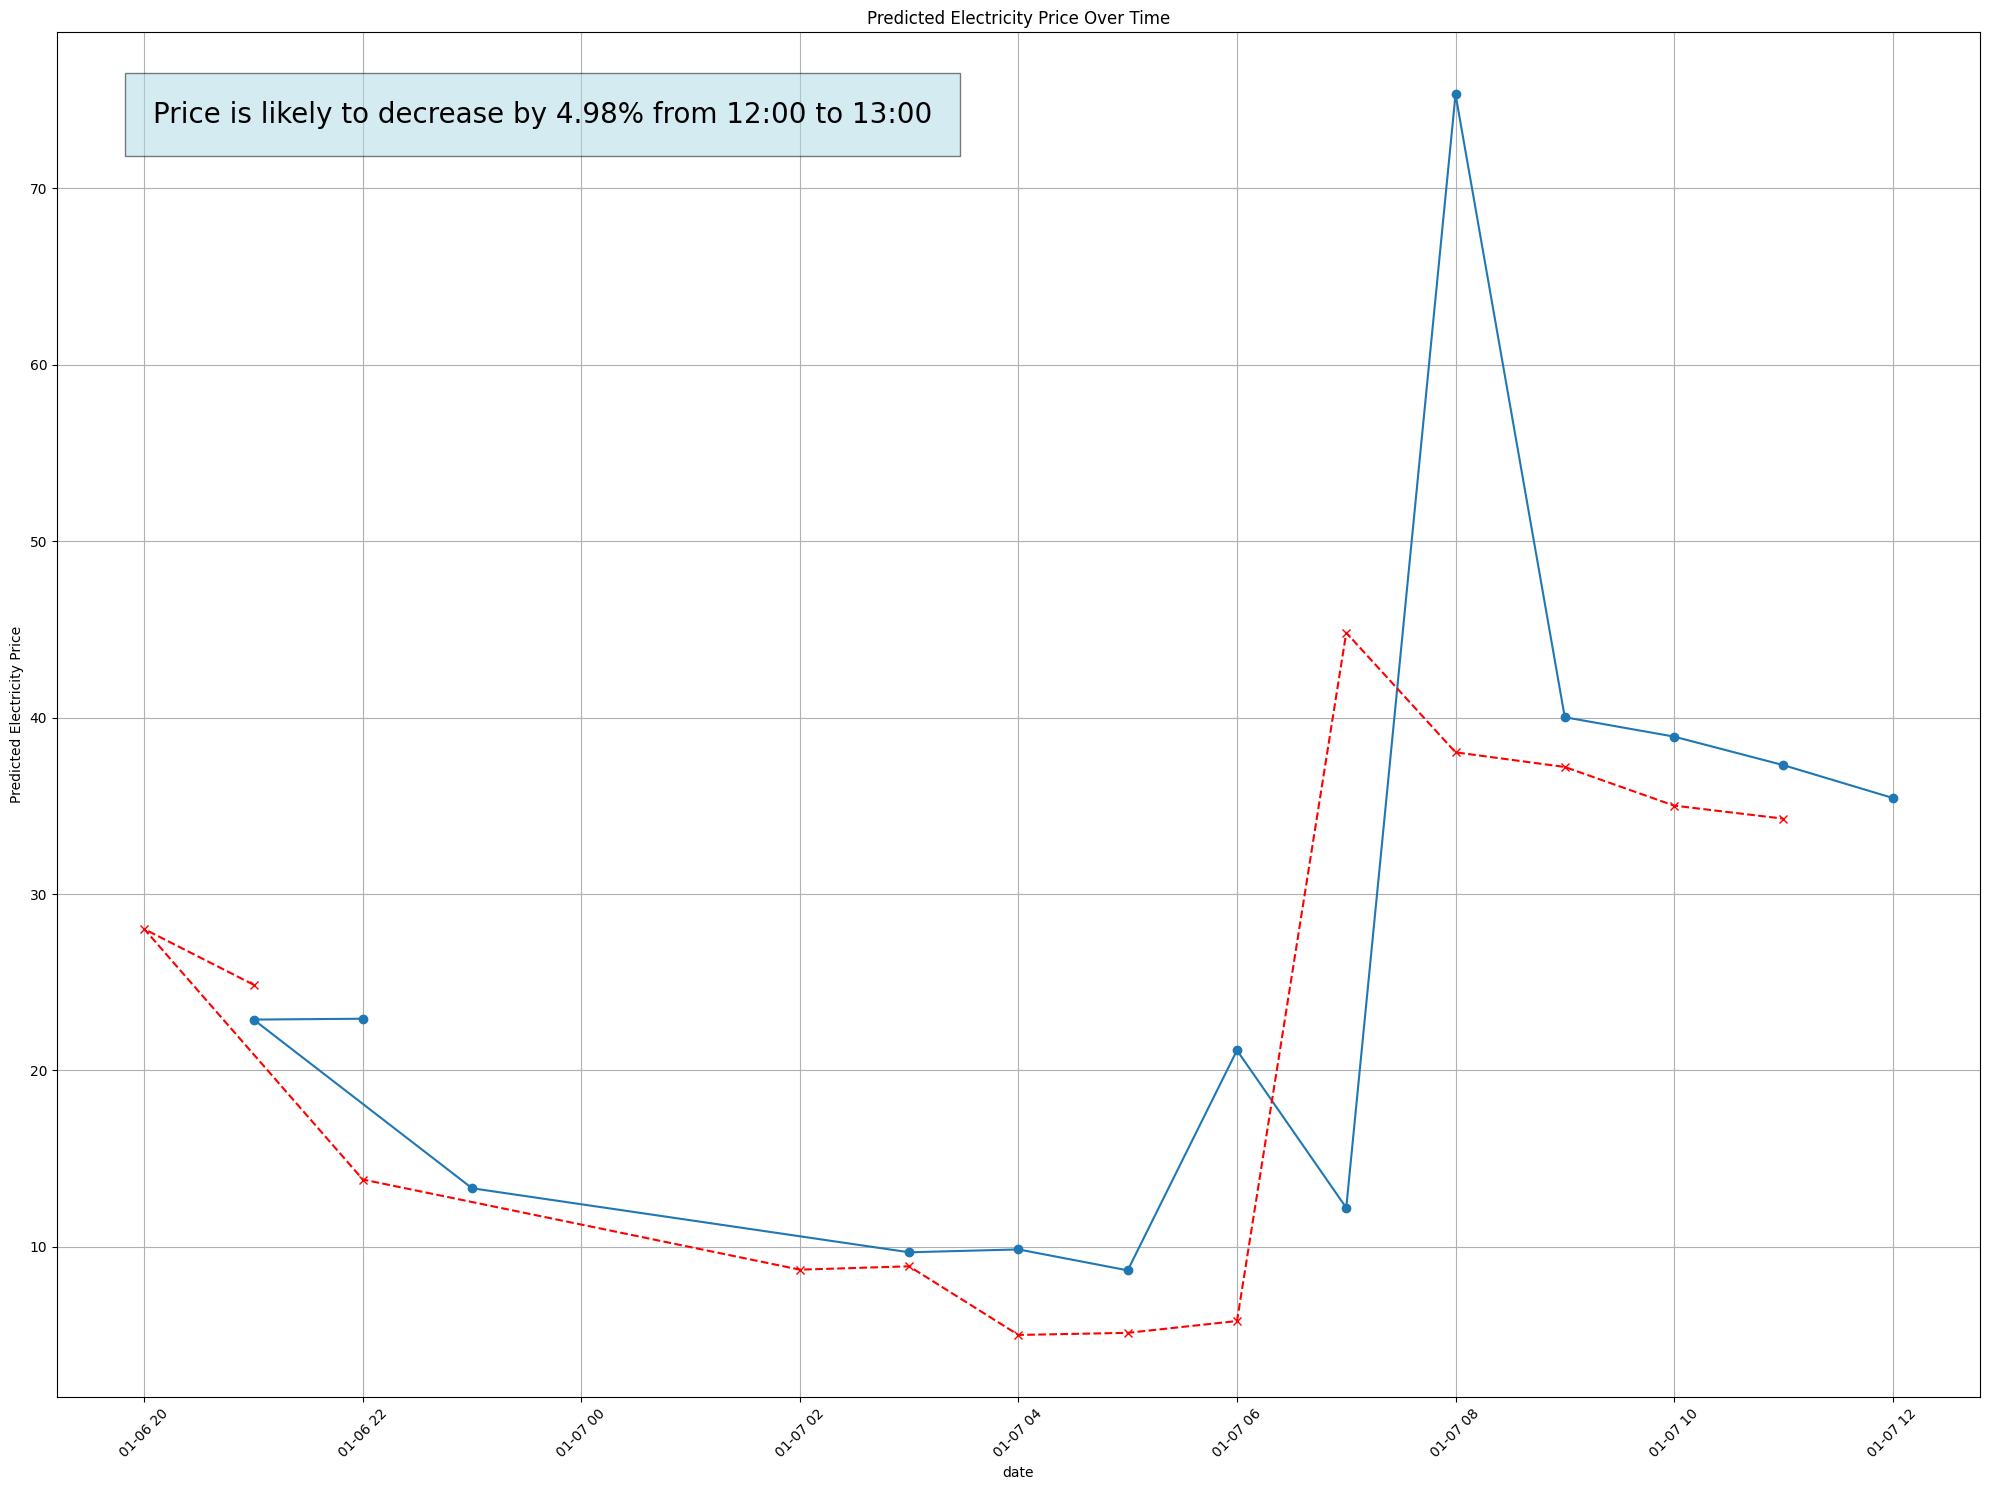

In [25]:
#batch_data['time_start'] = pd.to_datetime(batch_data['time_start'], errors='coerce')
#batch_data = batch_data.sort_values(by='date')

# if batch_data['time_start'].isnull().any():
#     raise ValueError("Some 'time_start' values could not be converted to datetime.")
#if 'predicted_electricity_price' not in batch_data.columns:
    #raise KeyError("'predicted_electricity_price' column does not exist in the DataFrame")
plt.figure(figsize=(20, 15))
plt.plot(plot_data['date']+pd.DateOffset(hours=2), plot_data['predicted_electricity_price'], marker='o', label='Predicted Price')
plt.plot(plot_data['date']+pd.DateOffset(hours=1), plot_data['prices'], marker='x', color='red', label='Actual Price', linestyle='--')


#plt.plot(plot_data['date'], plot_data['predicted_electricity_price'], marker='o')
plt.xlabel('date')
plt.ylabel('Predicted Electricity Price')
plt.title('Predicted Electricity Price Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.gca().text(
    x=0.05, 
    y=0.95, 
    s=text, 
    fontsize=20,
    verticalalignment='top',
    horizontalalignment='left',
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='lightblue', alpha=0.5, edgecolor='black', pad=20)
)

output_dir = 'Images/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'predicted_electricity_price_over_time_SE4.png')
plt.savefig(output_path)

plt.show()